In [1]:
import re

from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import neuralprophet
import numpy as np
import os
import plotly.express as px
from sklearn.metrics import mean_squared_error

C:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\bitcoin-price-predictor-Frh5AYeV-py3.10\lib\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
# no keys required for crypto data
client = CryptoHistoricalDataClient()

symbol = "BTC/USD"
request_params = CryptoBarsRequest(
    # symbol_or_symbols=["BTC/USD", "ETH/USD"],
    symbol_or_symbols=symbol,
    timeframe=TimeFrame.Hour,
    start=datetime.strptime("2023-07-01", '%Y-%m-%d')
)

bars = client.get_crypto_bars(request_params)

# convert to dataframe
btc = bars.df.loc[symbol].close

px.line(btc)

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=close<br>timestamp=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'close',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> close <i style="color:#fc9944">~4h</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'cc784c96-7686-4ab9-9ecf-89448fc917a0',
              'x': array([datetime.datetime(2023, 7, 1, 0, 0, tzinfo=TzInfo(UTC)),
                          datetime.datetime(2023, 7, 1, 3, 0, tzinfo=TzInfo(UTC)),
                          datetime.datetime(2023, 7, 1, 6, 0, tzinfo=TzInfo(UTC)), ...,
                          datetime.datetime(2023, 11, 30, 8, 0, tzinfo=TzInfo(UTC)),
                          datetime.datetime(2023, 11, 30, 12, 0, tzinfo=TzInfo(UTC)),
                          datetime.datetime(2023,

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.utils.configure_trainer) - Using accelerator cpu with 1 device(s).
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (112) is too small than the required number for the learning rate finder (239). The results might not be optimal.


Finding best initial lr:   0%|          | 0/239 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.973% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.973% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 112it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


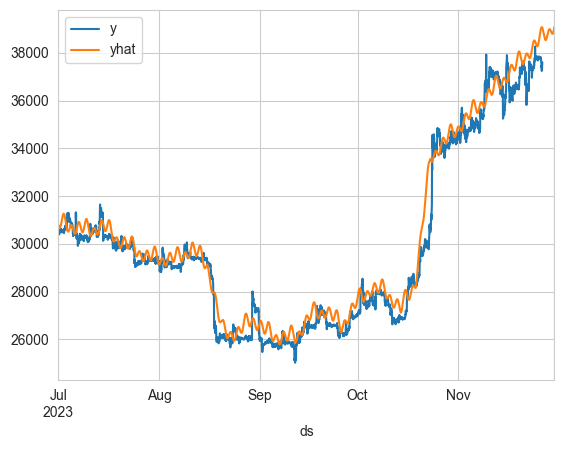

In [3]:
series = btc
lookback_period = 90
# Set index to datetime
series.index = pd.to_datetime(series.index)
series.index = series.index.tz_localize(None)

# sort by index
series.sort_index(inplace=True)

# Trim leading 0s, negative values, and np.nan values
first_good_idx = series.dropna()[series > 0].index[0]
series = series.loc[first_good_idx:]

# Convert series to correct format for Prophet model
ds = series.index
y = series.values.reshape(-1)
df_preprocessed = pd.DataFrame({"ds": ds, "y": y})

# Split df_preprocessed into train dataframe and lookback period dataframe
train_df, val_df = (
    df_preprocessed.iloc[: -lookback_period],
    df_preprocessed.iloc[-lookback_period :],
)

pi = 0.996  # prediction interval
qts = [
    (1 - pi) / 2,
    pi + (1 - pi) / 2,
]  # quantiles based on the prediction interval
# Default neural prophet params in a dict
neural_prophet_params = dict(
    quantiles=qts,
    loss_func="Huber",
    daily_seasonality=False,
    weekly_seasonality="auto",
    yearly_seasonality="auto",
    seasonality_mode="additive",
    normalize="auto",
    n_changepoints=25,
    n_lags=0,
    accelerator="cpu",
)

neural_prophet_params["n_forecasts"] = (
    lookback_period if neural_prophet_params.get("n_lags", 0) > 0 else 1
)

model = neuralprophet.NeuralProphet(**neural_prophet_params)

model.fit(
    train_df,
    freq='H',
    early_stopping=True,
    progress="bar",
    epochs=300,
)

future = model.make_future_dataframe(
    train_df,
    periods=lookback_period,
    n_historic_predictions=len(train_df),
)

prophet_forecast = model.predict(future)

# index of column name that starts with "yhat"
yhat_col_index = prophet_forecast.columns.str.startswith("yhat")
# replace string yhat with yhat1
# get all column names into a array
col_names = prophet_forecast.columns[yhat_col_index].values
yhatnames = [re.match(r"yhat(\d+)\s?", x).group(1) for x in col_names]
maxYhatName = "yhat" + min(yhatnames)
maxYhatNameRegexp = re.compile(maxYhatName + "($|\s)")
yhat_col_index_re = prophet_forecast.filter(regex=maxYhatNameRegexp).columns
# yhat_col_index = prophet_forecast.columns.str.startswith(maxYhatName)

prophet_forecast.rename(
    columns={yhat_col_index_re[0]: "yhat"},
    inplace=True,
)
prophet_forecast.rename(
    columns={yhat_col_index_re[1]: "yhat_lower"},
    inplace=True,
)
prophet_forecast.rename(
    columns={yhat_col_index_re[2]: "yhat_upper"},
    inplace=True,
)
fig, ax = plt.subplots(figize=plt.figaspect(1/3))
prophet_forecast.plot(x='ds', y=['y', 'yhat'], ax=ax)

train_forecast, val_forecast = (
    prophet_forecast.iloc[: -lookback_period],
    prophet_forecast.iloc[-lookback_period :],
)

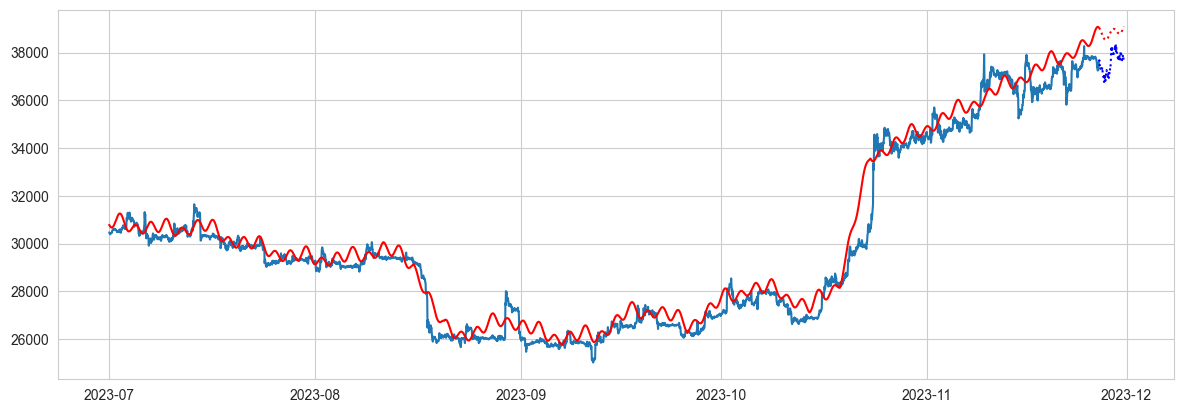

In [12]:
# Plot train/lookback dataframes for ground truth and forecasts
fig, ax = plt.subplots(figsize=plt.figaspect(1 / 3), facecolor="w")
ax.plot(
    train_df.ds,
    train_df.y,
    c="tab:blue",
    label="Ground Truth (Training)",
)
ax.plot(
    val_df.ds,
    val_df.y,
    "b:",
    label="Ground Truth (Lookback Period)",
)
ax.plot(
    train_forecast.ds,
    train_forecast.yhat,
    "r",
    label="Forecast (Training)",
)
ax.plot(
    val_forecast.ds,
    val_forecast.yhat,
    "r:",
    label="Forecast (Lookback Period)",
)

In [4]:
train_rmse = mean_squared_error(train_df.y, train_forecast.yhat, squared=False)
val_rmse = mean_squared_error(val_df.y, val_forecast.yhat, squared=False)

train_rmse, val_rmse

(654.1488416817849, 1280.4094988255226)

In [1]:
import torch
torch.cuda.is_available()

True

In [60]:
from lightning import Trainer
from lightning.pytorch.accelerators import find_usable_cuda_devices

# Find two GPUs on the system that are not already occupied
trainer = Trainer(accelerator="cuda", devices=find_usable_cuda_devices())

ValueError: You requested to find -1 devices but there are no visible CUDA devices on this machine.

In [53]:
prophet_forecast

,ds,y,yhat,yhat_lower,yhat_upper,trend,season_weekly
0,2023-07-01 00:00:00,30466.189525,30174.335938,28398.130859,32036.404297,30311.398438,-137.062210
1,2023-07-01 01:00:00,30437.826899,30177.582031,28199.582031,32063.542969,30310.986328,-133.403580
2,2023-07-01 02:00:00,30425.985000,30181.009766,27985.728516,32088.535156,30310.574219,-129.565506
3,2023-07-01 03:00:00,30384.935383,30184.533203,27758.609375,32110.748047,30310.164062,-125.630371
4,2023-07-01 04:00:00,30388.474456,30188.074219,27520.462891,32129.607422,30309.753906,-121.678696
...,...,...,...,...,...,...,...
3657,2023-11-30 09:00:00,NaN,39808.394531,36420.925781,46915.234375,39657.515625,150.875473
3658,2023-11-30 10:00:00,NaN,39810.437500,36326.527344,46827.859375,39666.734375,143.702667
3659,2023-11-30 11:00:00,NaN,39811.500000,36247.890625,46732.671875,39675.953125,135.545349
3660,2023-11-30 12:00:00,NaN,39811.632812,36186.117188,46630.664062,39685.171875,126.457947


In [48]:
date_range = pd.date_range(start='2020-01-01', periods=1000, freq='H')

# Generate 1000 random numbers
random_numbers = np.random.rand(1000)

# Create a DataFrame with 'ds' as datetime and 'y' as random numbers
train_df = pd.DataFrame({'ds': date_range, 'y': random_numbers})

model = neuralprophet.NeuralProphet()

model.fit(
    train_df,
    epochs=10,
)

future = model.make_future_dataframe(
    train_df,
    periods=90,
    n_historic_predictions=len(train_df),
)

p = model.predict(future, decompose=True, raw=False)
p

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (32) is too small than the required number for the learning rate finder (226). The results might not be optimal.


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.908% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.908% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 32it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_weekly,season_daily
0,2020-01-01 00:00:00,0.506144,0.177362,0.157337,0.001543,0.018482
1,2020-01-01 01:00:00,0.871015,0.153688,0.159027,0.001846,-0.007184
2,2020-01-01 02:00:00,0.946954,0.150470,0.160717,0.002033,-0.012280
3,2020-01-01 03:00:00,0.856699,0.166129,0.162407,0.002102,0.001621
4,2020-01-01 04:00:00,0.087336,0.165808,0.164097,0.002049,-0.000338
...,...,...,...,...,...,...
1085,2020-02-15 05:00:00,NaN,0.364616,0.388224,0.000857,-0.024466
1086,2020-02-15 06:00:00,NaN,0.355281,0.387836,0.000419,-0.032974
1087,2020-02-15 07:00:00,NaN,0.376032,0.387448,0.000041,-0.011457
1088,2020-02-15 08:00:00,NaN,0.384731,0.387060,-0.000268,-0.002060


In [49]:
model.predict(future, decompose=False, raw=False)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.908% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.908% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 32it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1
0,2020-01-01 00:00:00,0.506144,0.177362
1,2020-01-01 01:00:00,0.871015,0.153688
2,2020-01-01 02:00:00,0.946954,0.150470
3,2020-01-01 03:00:00,0.856699,0.166129
4,2020-01-01 04:00:00,0.087336,0.165808
...,...,...,...
1085,2020-02-15 05:00:00,NaN,0.364616
1086,2020-02-15 06:00:00,NaN,0.355281
1087,2020-02-15 07:00:00,NaN,0.376032
1088,2020-02-15 08:00:00,NaN,0.384731


In [14]:
model.predict(train_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 112it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,yhat1 0.2%,yhat1 99.8%,trend,season_weekly
0,2023-07-01 00:00:00,30466.189525,30463.400391,29095.285156,33192.960938,30577.613281,-114.213417
1,2023-07-01 01:00:00,30437.826899,30467.207031,29183.250000,33188.839844,30577.353516,-110.144753
2,2023-07-01 02:00:00,30425.985000,30471.222656,29272.595703,33185.257812,30577.091797,-105.869095
3,2023-07-01 03:00:00,30384.935383,30475.353516,29362.367188,33182.148438,30576.830078,-101.477211
4,2023-07-01 04:00:00,30388.474456,30479.509766,29451.619141,33179.441406,30576.570312,-97.059303
...,...,...,...,...,...,...,...
3567,2023-11-26 15:00:00,37453.195000,38616.835938,37470.078125,40441.085938,38764.250000,-147.414291
3568,2023-11-26 16:00:00,37245.615000,38626.234375,37477.894531,40459.570312,38772.542969,-146.306870
3569,2023-11-26 17:00:00,37287.255500,38636.535156,37491.921875,40479.187500,38780.835938,-144.298630
3570,2023-11-26 18:00:00,37261.784000,38647.753906,37512.351562,40499.953125,38789.125000,-141.371384


In [25]:
future = model.make_future_dataframe(
    train_df,
    periods=lookback_period,
    n_historic_predictions=len(train_df),
)
model.predict(future, decompose=False, raw=False)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.973% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.973% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 112it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,yhat1 0.2%,yhat1 99.8%
0,2023-07-01 00:00:00,30466.189525,30463.400391,29095.285156,33192.960938
1,2023-07-01 01:00:00,30437.826899,30467.207031,29183.250000,33188.839844
2,2023-07-01 02:00:00,30425.985000,30471.222656,29272.595703,33185.257812
3,2023-07-01 03:00:00,30384.935383,30475.353516,29362.367188,33182.148438
4,2023-07-01 04:00:00,30388.474456,30479.509766,29451.619141,33179.441406
...,...,...,...,...,...
3657,2023-11-30 09:00:00,NaN,39664.144531,39179.507812,41707.125000
3658,2023-11-30 10:00:00,NaN,39666.871094,39133.671875,41700.156250
3659,2023-11-30 11:00:00,NaN,39668.585938,39080.160156,41692.460938
3660,2023-11-30 12:00:00,NaN,39669.343750,39019.468750,41684.070312


In [15]:
model.predict(val_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 98.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 98.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 112it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,yhat1 0.2%,yhat1 99.8%,trend,season_weekly
0,2023-11-26 20:00:00,37600.1000,38672.968750,37572.730469,40544.964844,38805.710938,-132.740219
1,2023-11-26 21:00:00,37622.5345,38686.945312,37612.609375,40569.203125,38814.000000,-127.053551
2,2023-11-26 22:00:00,37674.5400,38701.812500,37658.750000,40594.570312,38822.292969,-120.482277
3,2023-11-26 23:00:00,37460.7450,38717.523438,37710.882812,40621.042969,38830.585938,-113.061691
4,2023-11-27 00:00:00,37500.8500,38734.039062,37768.660156,40648.578125,38838.875000,-104.837250
...,...,...,...,...,...,...,...
85,2023-11-30 09:00:00,37704.9400,39664.144531,39179.507812,41707.125000,39510.539062,153.605713
86,2023-11-30 10:00:00,37689.8300,39666.871094,39133.671875,41700.156250,39518.832031,148.036682
87,2023-11-30 11:00:00,37897.1800,39668.585938,39080.160156,41692.460938,39527.125000,141.464233
88,2023-11-30 12:00:00,37909.4400,39669.343750,39019.468750,41684.070312,39535.414062,133.929092
